In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
# from sklearn.ensemble import RandomForestRegressor
# import time
# import warnings # prevent warnings
# import joblib
from sklearn import metrics
import sys
import pickle

In [2]:
site = 'C'

In [3]:
# load the data
# get parent directory
os.chdir("../..")

# import file
sys.path.append(os.getcwd() + '\QRANN')
from evaluation import eval_prediction, pivot, plot_heatmap, plot_time, plot_2pcurve, plot_res, plot_reshistogram, plot_pcurve, plot_res_vs_var

data_directory = 'Data_clean'
all_data = site + '_data_clean.csv'
train_data = site + '_data_train.csv'

data = pd.read_csv(os.path.join(os.getcwd(), data_directory, all_data), index_col = 0)
data_train = pd.read_csv(os.path.join(os.getcwd(), data_directory, train_data), index_col = 0)

# reset to current directory
fd = sys.path[0]
os.chdir(fd)

In [4]:
# Add week number
data['ts'] = pd.to_datetime(data['ts'], format = '%Y-%m-%d %H:%M:%S')
data['Week'] = data.ts.dt.isocalendar().week

# Rearrange columns
data = data.reindex(columns = ['ts', 'Month', 'Day', 'Hour', 'Week', 'instanceID', 'Wind_speed', 'TI',
       'Temperature', 'Power'])

In [5]:
# load trained models 
trained_forest = pickle.load(open(os.path.join(os.getcwd(), "trained_forest.pkl"),'rb'))

### Predict (using train data, to calculate sigma)

In [6]:
%%time
# prediction
# create a list of turbine IDs
turbines = data.instanceID.unique()
# create an empty dataframe to store the results
results_train = pd.DataFrame

# loop over each turbine
for ID in turbines:
    
    # select data based on turbine ID
    data_temp = data_train[data_train['instanceID'] == ID]
    
    # get X
    X = data_temp.iloc[:, 5:-1].values
    
    # load model based on turbine number
    forest_temp = trained_forest[ID]

    # predict
    pred = forest_temp.predict(X)

    # concatenate results by column
    data_temp = pd.concat([data_temp, pd.Series(pred, index = data_temp.index.values, name = 'Predicted_power')], axis = 1)
    
    # concatenate results by row
    if results_train.empty: 
        results_train = data_temp
    else:
        results_train = pd.concat([results_train, data_temp], axis = 0)
    
    print('Done ', ID)

Done  C_WTG02
Done  C_WTG04
Done  C_WTG05
Done  C_WTG06
Done  C_WTG07
Done  C_WTG08
Done  C_WTG09
Done  C_WTG12
Done  C_WTG13
Done  C_WTG17
Done  C_WTG16
Done  C_WTG21
Done  C_WTG10
Done  C_WTG11
Done  C_WTG01
Done  C_WTG18
Done  C_WTG19
Done  C_WTG14
Done  C_WTG15
Done  C_WTG20
Done  C_WTG03
Wall time: 2.17 s


In [7]:
results_train.head()

,ts,Month,Day,Hour,instanceID,Wind_speed,TI,Temperature,Power,Predicted_power
410299,2020-05-15 16:20:00,5,15,16,C_WTG02,7.184900,9.962361,7.136207,1096.866811,981.110057
890758,2020-10-21 13:30:00,10,21,13,C_WTG02,3.264120,15.296064,10.820000,31.812128,50.234618
320020,2020-04-15 19:50:00,4,15,19,C_WTG02,3.461468,19.180626,6.300000,104.291399,88.059705
332053,2020-04-19 19:20:00,4,19,19,C_WTG02,9.210330,6.769892,10.166667,1900.354159,1848.629967
648292,2020-08-02 09:10:00,8,2,9,C_WTG02,3.642551,21.334941,13.145000,74.006387,88.480718


In [8]:
# create dataframe for the results
# calculate the error (= residual)
results_train = results_train.assign(Error = results_train['Predicted_power'] - results_train['Power'])

In [9]:
# define centre line(residual mean) and sigma(residual standard deviation) 
res_mean = results_train['Error'].mean()
sigma_3 = 3*results_train['Error'].std()
sigma_2 = 2*results_train['Error'].std()
sigma_1 = 1*results_train['Error'].std()
print("The residual mean is", res_mean)
print("The residual standard deviation is", sigma_1)

The residual mean is 0.18810803078606791
The residual standard deviation is 49.6390437022171


### Predict (using entire wind farm data)

In [10]:
%%time
# prediction
# create a list of turbine IDs
turbines = data.instanceID.unique()
# create an empty dataframe to store the results
results = pd.DataFrame

for ID in turbines:
    
    # select data based on turbine ID
    data_temp = data[data['instanceID'] == ID]
    
    # get X
    X = data_temp.iloc[:, 6:-1].values
    
    # load model based on turbine number
    forest_temp = trained_forest[ID]

    # predict
    pred = forest_temp.predict(X)

    # concatenate results by column
    data_temp = pd.concat([data_temp, pd.Series(pred, index = data_temp.index.values, name = 'Predicted_power')], axis = 1)
    
    # concatenate results by row
    if results.empty: 
        results = data_temp
    else:
        results = pd.concat([results, data_temp], axis = 0)
    
    print('Done ', ID)

Done  C_WTG02
Done  C_WTG04
Done  C_WTG05
Done  C_WTG06
Done  C_WTG07
Done  C_WTG08
Done  C_WTG09
Done  C_WTG12
Done  C_WTG13
Done  C_WTG17
Done  C_WTG16
Done  C_WTG21
Done  C_WTG10
Done  C_WTG11
Done  C_WTG01
Done  C_WTG18
Done  C_WTG19
Done  C_WTG14
Done  C_WTG15
Done  C_WTG20
Done  C_WTG03
Wall time: 9.6 s


In [11]:
results.head()

,ts,Month,Day,Hour,Week,instanceID,Wind_speed,TI,Temperature,Power,Predicted_power
1,2020-01-01 00:00:00,1,1,0,1,C_WTG02,4.062859,11.707602,4.273333,144.951967,124.498891
22,2020-01-01 00:10:00,1,1,0,1,C_WTG02,4.846914,14.856238,4.400000,241.911755,272.836917
43,2020-01-01 00:20:00,1,1,0,1,C_WTG02,4.945137,11.742346,4.470000,252.295768,285.550128
64,2020-01-01 00:30:00,1,1,0,1,C_WTG02,5.251834,10.815515,4.516667,287.445673,342.580418
85,2020-01-01 00:40:00,1,1,0,1,C_WTG02,5.313850,10.067187,4.612069,340.274619,358.156004


In [12]:
# create dataframe for the results
# calculate the error (= residual)
results_all = results.assign(Error = results['Predicted_power'] - results['Power'])

In [13]:
# construct a 95% confidence interval
UCL = res_mean + sigma_2
LCL = res_mean - sigma_2

In [14]:
# classify outlier 
results_all['Outlier_pred'] = ((results_all['Error'] < LCL) | (results_all['Error'] > UCL))
results_all['Under_pred'] = (results_all['Error'] < LCL)
results_all['Over_pred'] = (results_all['Error'] > UCL)
results_all['Sample_count'] = 1

### Performance

In [15]:
# compute and print the performance of prediction 
RMSE, MAE = eval_prediction(results_all)
print('The root mean square error (RMSE) is', RMSE)
print('The mean absolute error (MAE) is', MAE)

The root mean square error (RMSE) is 49.53421687637723
The mean absolute error (MAE) is 34.68571679994926


### Examine the residuals

In [16]:
# select a turbine
temp_data = results_all[results_all['instanceID'] == site + '_WTG05']
temp_outlier = temp_data[(temp_data['Under_pred'] == 1) | (temp_data['Over_pred'] == 1)]

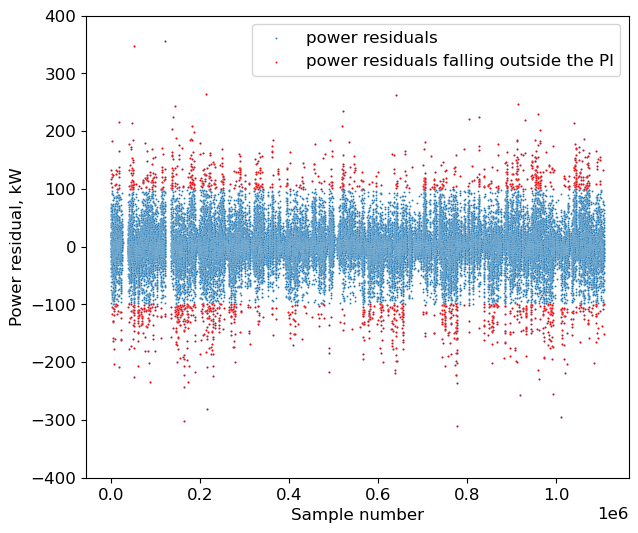

In [17]:
# plot the residuals
plot_res(temp_data, temp_outlier, ylim = 400, outlier = True)

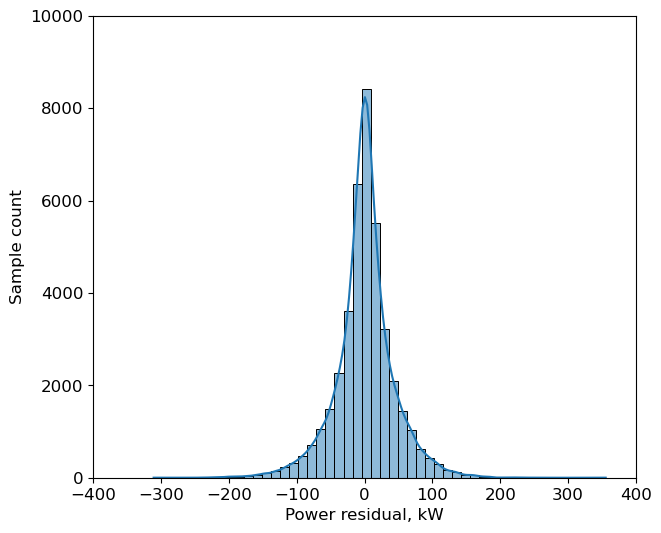

In [18]:
# plot the histogram of the residuals
plot_reshistogram(temp_data, xlim = 400, ylim = 10000)

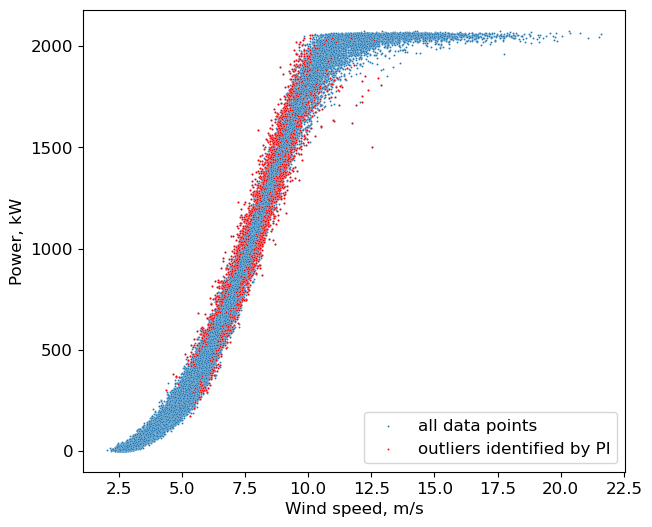

In [19]:
# plot the power curve 
plot_pcurve(temp_data, temp_outlier, outlier = True)

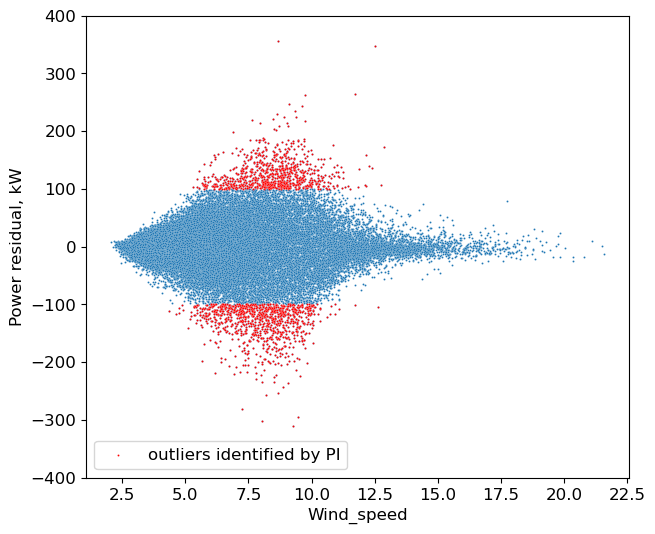

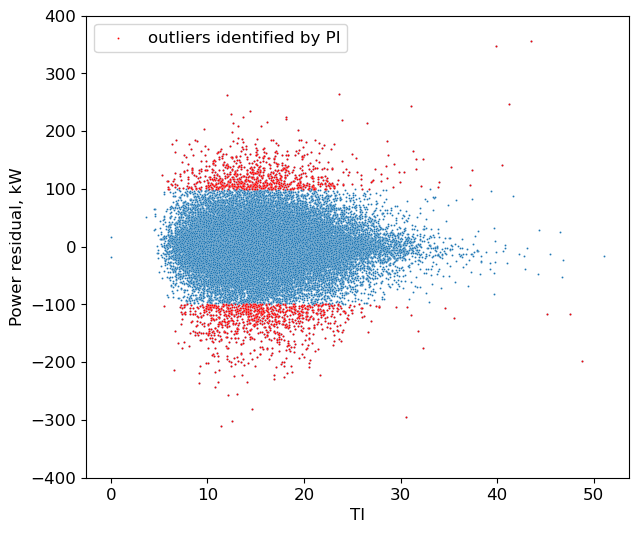

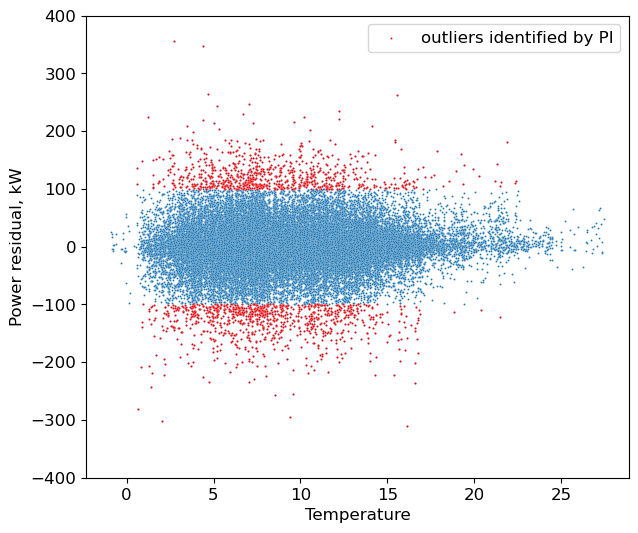

In [20]:
# plot the residuals vs wind speed/TI/temperature
# note: heteroscedasticity
plot_res_vs_var(temp_data, temp_outlier, "Wind_speed", ylim = 400, outlier = True)
plot_res_vs_var(temp_data, temp_outlier, "TI", ylim = 400, outlier = True)
plot_res_vs_var(temp_data, temp_outlier, "Temperature", ylim = 400, outlier = True)